In [1]:
import os, sys
sys.path.insert(1, os.getcwd()) 
sys.path.append("..")

In [2]:
import math

import numpy as np
from scipy.signal import cwt, ricker, argrelextrema
from matplotlib import pyplot as plt

import src.uilc as uilc

In [3]:
#Optical system setting
cm = 1E-2
s = 30
W = 9*cm
H = 3*cm

In [4]:
ds_rho, ds_position, ds_F = uilc.DISOP.solve_linear(s, W, H)
#ds_lamb = 20*(ds_rho.size) / (W*ds_rho.sum())
#ds_rho = ds_lamb * ds_rho

AttributeError: module 'src.uilc' has no attribute 'DISOP'

In [6]:
# Maximum quantization level for positive solution
len(ds_rho)

17

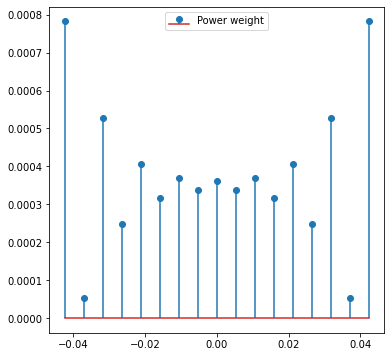

In [7]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
ax.stem(ds_position, ds_rho)
ax.legend(["Power weight"])
plt.show()

Extend weight value for signal processing method

In [10]:
period = ds_position[-1] - ds_position[0]

In [11]:
p1 = ds_position[:-1] - period
p2 = ds_position
p3 = ds_position[1:] + period

position = np.concatenate([p1 , p2, p3], axis =0 )

rho1 = ds_rho[:-1]
rho2 = ds_rho
rho3 = ds_rho[1:]

rho = np.concatenate([rho1, rho2 , rho3], axis=0)

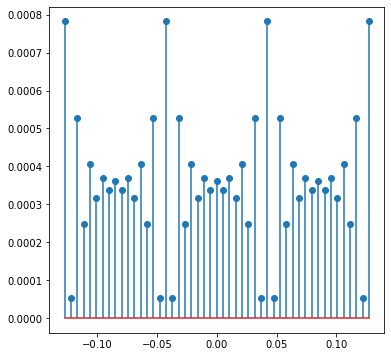

In [12]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
ax.stem(position, rho)
plt.show()

DC blocking

In [13]:
from scipy import fft
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from copy import deepcopy

In [14]:
sampling_rate = len(rho)/W
Fx = fft.fft(ds_rho)
freq = fft.fftfreq(len(ds_rho)) * sampling_rate
rho_f = deepcopy(Fx)
rho_f[0] = 0. # DC blocking
ds_rho_dc_blocked = fft.ifft(rho_f).real
constant_sig = ds_rho[0] - ds_rho_dc_blocked[0] # Blocked value of signal

In [15]:
rho_blocked = rho-constant_sig
enveloped_signal = np.abs(hilbert(rho_blocked))

In [16]:
cu2 = interp1d(position, rho_blocked, kind='quadratic', fill_value="extrapolate")
xew = np.linspace(-(W/2), (W/2), num= 500, endpoint=True)
enveloped_signal_2 = np.abs(hilbert(cu2(xew)))

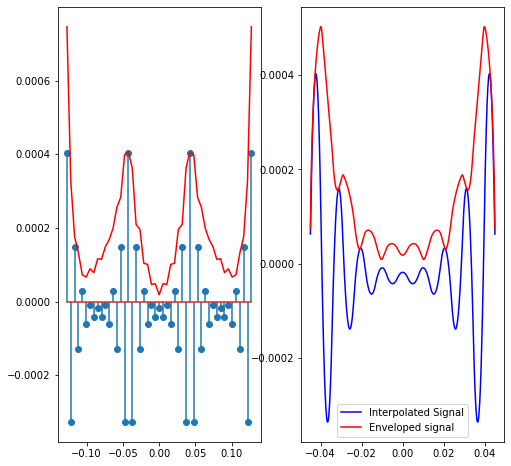

In [17]:
figure, axes = plt.subplots(1, 2, figsize= (8,8))
axes[0].stem(position, rho_blocked)
axes[0].plot(position, enveloped_signal, color = "red")
axes[1].plot(xew, cu2(xew), color= "blue")
axes[1].plot(xew, enveloped_signal_2, color= "red")
axes[1].legend(["Interpolated Signal", "Enveloped signal"])
plt.show()

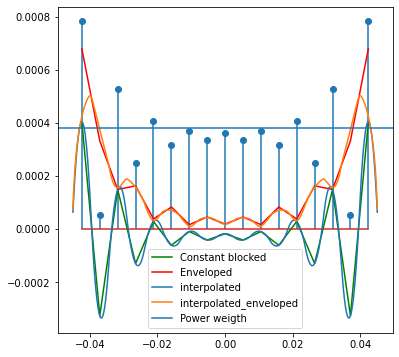

In [19]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
ax.stem(ds_position, ds_rho)
ax.plot(ds_position, ds_rho_dc_blocked, "green")
ax.plot(ds_position, np.abs(hilbert(ds_rho_dc_blocked)), color="red")
ax.plot(xew, cu2(xew))
ax.plot(xew, enveloped_signal_2)
ax.axhline(constant_sig)
ax.legend(["Constant blocked", "Enveloped", "interpolated", "interpolated_enveloped", "Power weigth"])
plt.show()

In [24]:
N = argrelextrema(ds_rho, np.greater)[0].size+2
f = N/W # Period = W/N
sig_carrier = np.cos(2 * np.pi * f *xew)

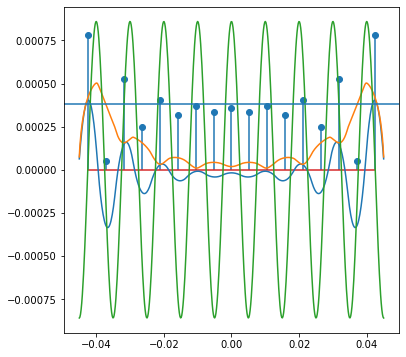

In [25]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
ax.stem(ds_position, ds_rho)
ax.plot(xew, cu2(xew))
ax.plot(xew, enveloped_signal_2)
ax.plot(xew, 1.1 * sig_carrier * max(ds_rho))
ax.axhline(constant_sig)
plt.show()

FM modulation with enveloped weight

In [27]:
from scipy.integrate import simpson

# Generate instantaneous phase routine from message signal
def phase(t, timezone, xm):
    if timezone.shape != xm.shape:
        raise ValueError("time data and signal data are not in same dimension.")
    
    if t < timezone.min() or t> timezone.max():
        raise ValueError(f"Exceed the range ({timezone.min()}, {timezone.max()})")
    
    index_values = np.where(timezone > t)[0]
    if len(index_values) == 0:
        index = len(index_values)
    else:
        index= index_values[0]

    if index == 0 :
        return 0
    return simpson(xm[:index], timezone[:index])
vphase = np.vectorize(phase, excluded=['timezone', 'xm']) # vertorize

In [28]:
message_phase = vphase(xew, timezone = xew, xm = enveloped_signal_2/max(enveloped_signal_2))

In [29]:
message_phase -= (message_phase.max() + message_phase.min())/2

In [35]:
message_phase[-1]

-0.013495103803663387

In [36]:
message_phase[0]

-0.013495103803663387

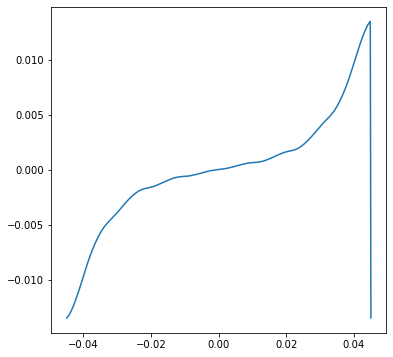

In [37]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
ax.plot(xew, message_phase)
plt.show()

In [38]:
fd = 0
fd_d = 10
phase = f * xew + fd * message_phase
sig_fm = np.cos(2* np.pi * phase)
sources_init = argrelextrema(sig_fm, np.greater)[0].size
sources = sources_init

In [39]:
fd_i = 0
fd_f = 0

In [40]:
while( sources < sources_init + 4):
    fd += fd_d
    phase = f * xew + fd * message_phase
    sig_fm = np.cos(2* np.pi * phase)
    sources= argrelextrema(sig_fm, np.greater)[0].size

    if sources == sources_init+2:
        fd_i = fd
fd_f = fd

In [41]:
print(fd_i, fd_f)

110 120


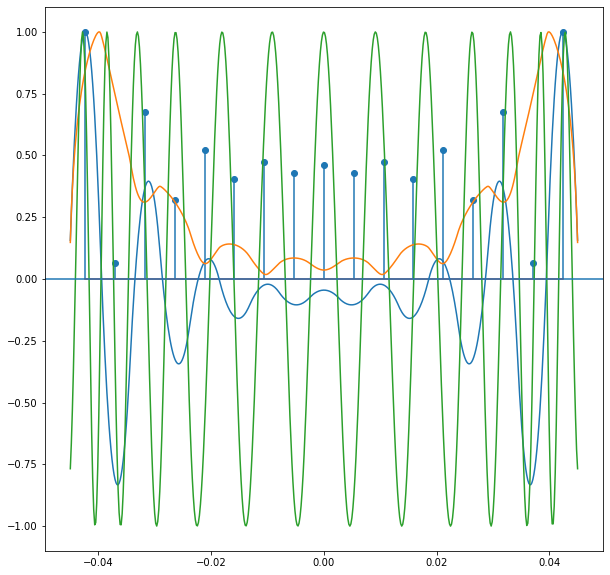

In [42]:
fd = 140
phase = f * xew + fd * message_phase
sig_fm = np.cos(2* np.pi * phase)
figure= plt.figure(figsize=(10,10))
ax = figure.add_subplot()
ax.stem(ds_position, ds_rho/max(ds_rho))
ax.plot(xew, cu2(xew)/max(cu2(xew)))
ax.plot(xew, enveloped_signal_2/max(enveloped_signal_2))
ax.plot(xew, sig_fm /max(sig_fm))
ax.axhline(constant_sig)
plt.show()

In [43]:
def get_extremvalues(position, signal):
    index = argrelextrema(signal, np.greater)[0]
    return position[index], signal[index]
    

In [44]:
pos, sig = get_extremvalues(xew, sig_fm)

In [45]:
pos

array([-4.28356713e-02, -3.85070140e-02, -3.30961924e-02, -2.64228457e-02,
       -1.81262525e-02, -9.10821643e-03, -9.01803607e-05,  9.10821643e-03,
        1.79458918e-02,  2.62424850e-02,  3.30961924e-02,  3.85070140e-02,
        4.28356713e-02])

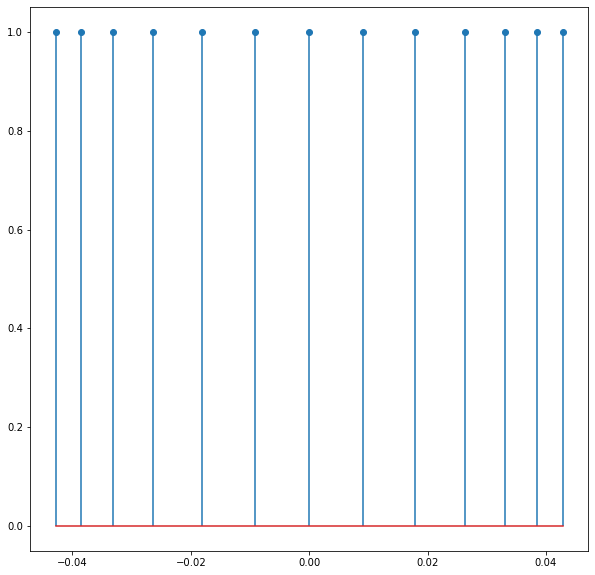

In [46]:
figure= plt.figure(figsize=(10,10))
ax = figure.add_subplot()
ax.stem(pos, np.ones(len(pos)))
plt.show()

In [96]:
source_array = uilc.Utils.get_2d_array(arr= pos, axis="x")

IndexError: tuple index out of range

In [98]:
test_array = uilc.Utils.get_2d_array(np.array([-2, -1, 0, 1, 2]), np.array([-2, -1, 0, 1, 2]))

In [99]:
uilc.Utils.get_axis_list(test_array, axis="x")

array([ 2,  1,  0, -1, -2])

In [102]:
uilc.Utils.getlocation(1, 0, test_array)

array([1, 2])

In [104]:
test_array[0][1]

array([1, 2])

# Below: Tests and in studying

In [ ]:
nnls_n = 45
nnls_rho, nnls_position, nnls_F = uilc.DISOP.solve_nnls(s, W, H, nnls_n, mean=False)

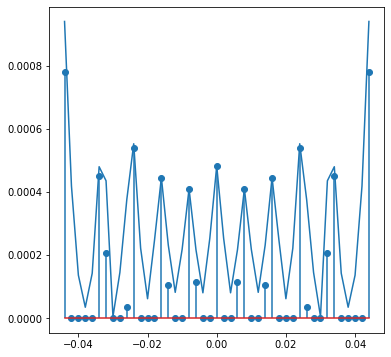

In [ ]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
ax.stem(nnls_position, nnls_rho)
ax.plot(nnls_position, np.abs(hilbert(nnls_rho)))
plt.show()

In [ ]:
d = nnls_position[1] - nnls_position[0]
nnls_pos_ext = np.insert(nnls_position, len(nnls_position)-1, nnls_position[len(nnls_position)-1] + d)
nnls_pos_ext = np.insert(nnls_pos_ext, 0, nnls_position[0] - d)
nnls_rho_ext = np.insert(nnls_rho, len(nnls_rho)-1, 0)
nnls_rho_ext = np.insert(nnls_rho_ext, 0 , 0)


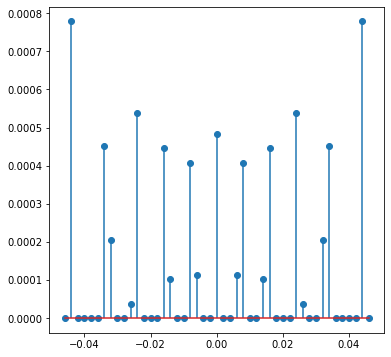

In [ ]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
ax.stem(nnls_pos_ext, nnls_rho_ext)
plt.show()

In [ ]:
nnls_position[len(nnls_position)-1] + d

0.046

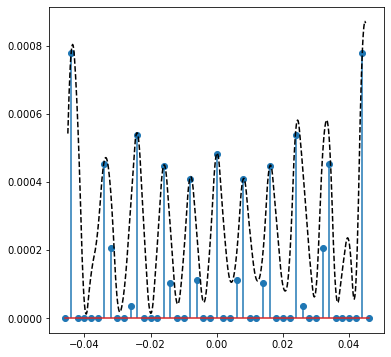

In [ ]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
#ax.bar(nnls_pos_ext, nnls_rho_ext, width=W/len(nnls_rho), edgecolor="white", linewidth=0.7 )
ax.stem(nnls_pos_ext, nnls_rho_ext)
ax.plot(xew, cu2(xew), '--', color='black')
plt.show()

Applying Wavelet transform

In [ ]:
from scipy.signal import cwt
from scipy.signal import ricker as wavelet_ricker
from scipy.signal import argrelextrema

def ricker(xline, position, weight, rho):
    y= np.zeros(xline.size)
    for i, pos in enumerate(position):
        y += weight[i] * (1- np.power((xline-pos)/rho,2))*np.exp(-np.power(xline-pos,2)/(2* rho**2))
    return y

In [ ]:
width = np.arange(0.1, 20, 0.01)
cwtmatr = cwt(nnls_rho, wavelet_ricker, width)

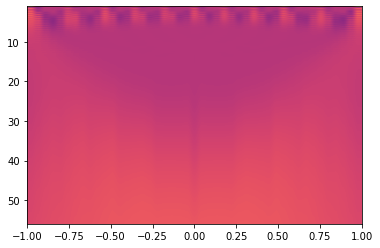

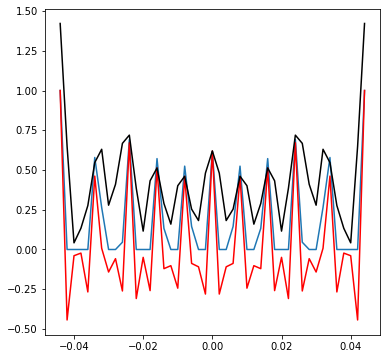

In [ ]:
plt.imshow(cwtmatr, extent=[-1, 1, 56, 1], cmap='magma', aspect='auto',
           vmax=abs(cwtmatr.max()), vmin=-abs(cwtmatr.max()))
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
ax.plot(nnls_position, nnls_rho/max(nnls_rho))
i = 50
cwt_norm = cwtmatr[i]/max(cwtmatr[i])
ax.plot(nnls_position, cwt_norm, color="red")
ax.plot(nnls_position, np.abs(hilbert(cwt_norm)), color="black")
plt.show()

In [ ]:
len(argrelextrema(np.abs(hilbert(cwt_norm)), np.greater)[0])

9

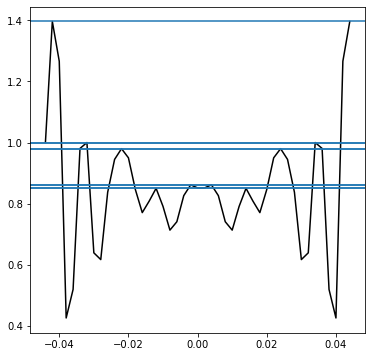

In [ ]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
i = 80
cwt_norm = cwtmatr[i]/max(cwtmatr[i])
enveloped = np.abs(hilbert(cwt_norm))
peaks = argrelextrema(enveloped , np.greater)[0]
ax.plot(nnls_position, enveloped, color="black")

for peak in peaks:
    ax.axhline(y = enveloped[peak])
plt.show()

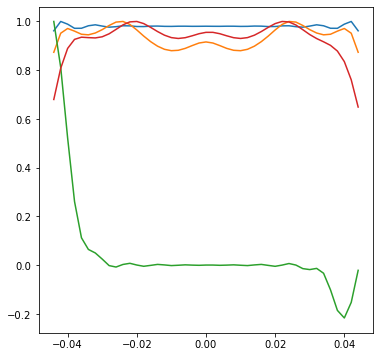

In [ ]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot()
I = [
    nnls_F.dot(nnls_rho),
    nnls_F.dot(np.abs(hilbert(nnls_rho))),
    nnls_F.dot(cwt_norm),
    nnls_F.dot(enveloped)
]
for i in I:
    ax.plot(nnls_position, i/max(i))
#ax.set_ylim([0, 5])
plt.show()
